# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Будюк".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [19]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.1, n_batch=100, max_epoch=100):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C # Параметр регуляризации 
        self.alpha = alpha # Скорость спуска
        self.max_epoch = max_epoch # Число эпох 
        self.n_batch = n_batch # Число батчей
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        N = X.shape[0] # Количество наблюдений
        p = X.shape[1] # Количество предиктор
        self.beta = np.ones(p+1) # Параметры модели
        self.epoch_L = np.zeros(self.max_epoch) # Ошибка за одну эпоху
        gradient = np.zeros(p+1) # Градиент 
        X = np.c_[X, np.ones(X.shape[0])] # Расширенная матрица с данными
        g = np.zeros(N) # Линейная функция 
        delta = 10 
        eps = 0.001
        epoch = 0
        L_prev = 0
        batch_size = N/self.n_batch + (N%self.n_batch!=0)
        
        while (delta > eps) and (epoch < self.max_epoch):
            start =0
            fin =0
            shuffle = np.random.permutation(N)
            epoch += 1 
            #print epoch
            
            while (fin != N):
                # считаем значение функции потерь
                g = X.dot(self.beta)
                start =fin
                fin += batch_size
                if fin > N:
                    fin = N
                index = shuffle[start:fin]
                
                L = -1.0/(fin-start) * ((y[index]==1) * np.log(sigmoid(g[index])) + \
                      (y[index]==0) * np.log(1 - sigmoid(g[index]))).sum() + self.C * \
                        ((self.beta**2)[:-1]).sum()/(2*(fin-start))
                
                #print L
                #delta = abs(L - L_prev)
                #L_prev = L
                self.epoch_L[epoch-1]+= L

                # считаем градиент
                gradient = -1.0/(fin-start) * (((y[index]==1) *(1 - sigmoid(g[index])) - \
                    (y[index]==0) * sigmoid(g[index])).reshape(-1,1) * X[index]).sum(axis=0) +\
                        2 * self.C * np.hstack((self.beta[:-1],0)) /(2*(fin-start))
            
                # обновляем коэффициенты
                self.beta -= (self.alpha / epoch) * gradient
            #print self.beta
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        #self.fit(X,y)
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.c_[X, np.ones(X.shape[0])]
        y_hat = X.dot(self.beta)
        
        return 1*(y_hat>0)
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.c_[X, np.ones(X.shape[0])]
        y_hat_proba = sigmoid(X.dot(self.beta))
        
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

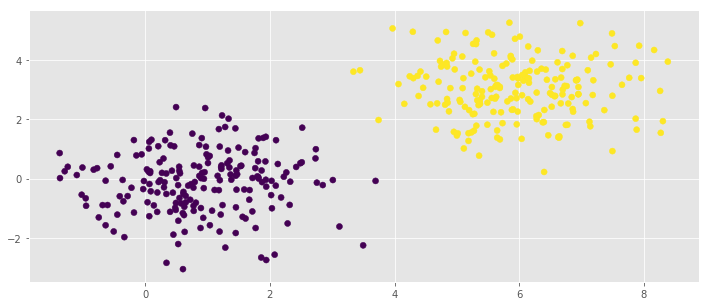

In [4]:
np.random.seed(0)

C11 = np.array([[1., 0.], [0., 1.]])
C22 = np.array([[1., 0.], [0., 1.]])
gauss11 = np.dot(np.random.randn(200, 2) + np.array([6, 3]), C11)
gauss22 = np.dot(np.random.randn(200, 2) + np.array([1, 0]), C22)

X1 = np.vstack([gauss11, gauss22])
y1 = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X1[:,0], X1[:,1], c=y1)

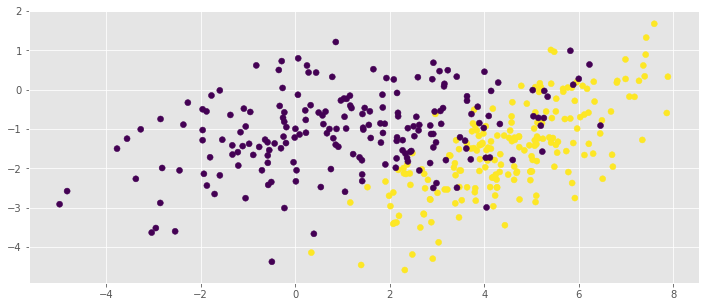

In [5]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

1
1.18994515671
0.607631728152
0.672934968238
1.15156834348
0.306161531345
1.02394284754
0.650045789354
0.999588467758
0.987752830957
0.70896070381
0.54831437947
0.604997319112
1.07235416797
0.416377829759
1.33044465554
0.753198578049
0.595304085042
0.653045178074
0.762185035447
0.567884842158
0.496133252646
0.376810312733
0.501058280728
0.549688018267
0.666262283747
0.534579585878
0.641690192968
0.601790549338
0.719556547028
[ 0.45715079 -0.09921532 -1.13401481]
2
0.563431180094
0.391918587199
0.144536799989
0.471366646008
0.743819444377
0.386294773453
0.304714496738
0.570998272223
0.3304253636
0.312083139953
0.550354529223
0.448590458624
0.420156310092
0.410415245414
0.480721616677
0.584975895322
0.418802363593
0.496672601878
0.498936822193
0.485608851536
0.489510879176
0.471687697588
0.440297873716
0.302948826046
0.519401678741
0.267180259792
0.360895416818
0.501202475047
0.478744950672
[ 0.33581405 -0.22726726 -1.81351256]
3
0.435907786495
0.438291854567
0.459867024612
0.4340468910

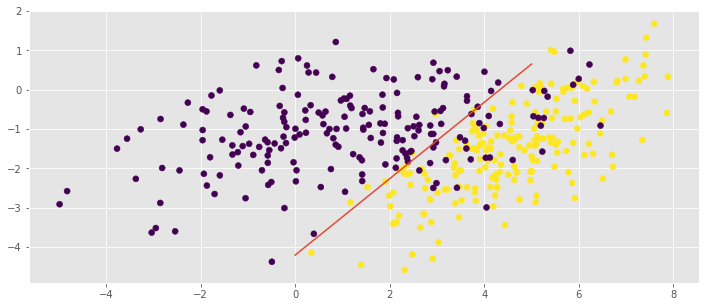

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score

xx = np.arange(0,6,1)
model = MySGDClassifier(C=0.01, alpha=0.6, n_batch=30, max_epoch=70)
model.fit(X, y)
y_hat = model.predict(X)
print 'accuracy_score: ', accuracy_score(y, y_hat)
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(xx,(xx*model.beta[0]+model.beta[2])/(-model.beta[1]))

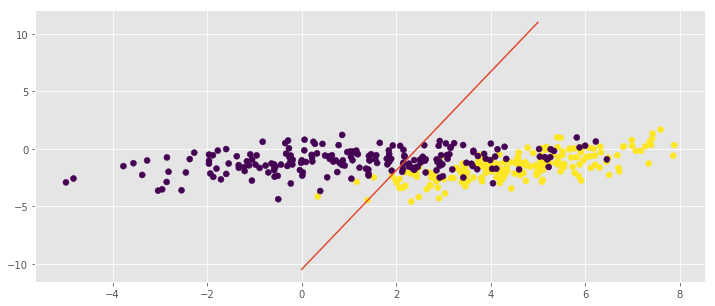

In [7]:
from sklearn.linear_model import SGDClassifier
model1 =  SGDClassifier(loss='log', alpha=1) 
y_hat1 = model1.fit(X, y).predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(xx,(xx*model1.coef_[:,0]+model1.intercept_)/(-model1.coef_[:,1]))

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

1
0.578148801208
2.20838546506
1.21540324486
1.23424544828
0.112997960733
1.10792004162
0.688035192152
0.299735905808
1.29318258274
0.842164861835
2.30446437586
0.0526250068878
0.334290509495
0.630422220653
1.60451760744
0.502826935384
1.80696133969
1.40524118918
1.23654186031
0.0300440278797
0.0363502474661
2.04930840964
0.167969290891
0.485588745116
0.128471926922
1.44467605458
0.764027031323
1.19152483036
0.313139003564
0.376508721195
0.784531387943
0.340448289356
0.695722690701
1.8281783285
0.161476766187
0.880180761372
0.0233552546015
0.310311522985
1.68944459132
1.05770076827
0.0925728418268
1.00257975612
0.905911185978
1.38182240429
1.99761196447
0.508047161958
1.88517180239
0.38710829709
0.137906083981
1.30290761349
0.872971010633
0.214174102677
0.821353244098
1.09292921398
0.603162905304
0.395413226978
1.15612299489
0.395959210914
1.74530603507
0.485060591634
1.8552774833
1.49095785978
1.04113701351
1.23182762362
0.150842453278
0.677408360473
0.891612421204
0.47923157012
1.180

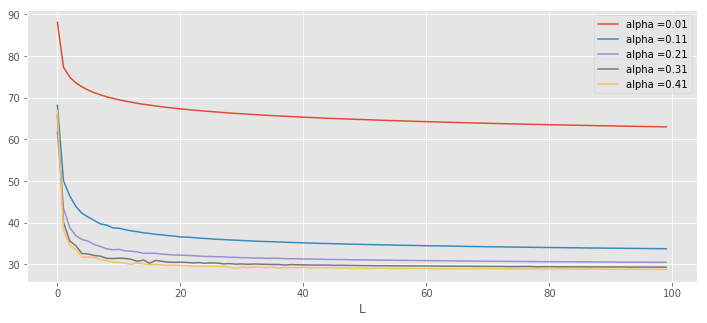

In [8]:
alpha = np.arange(0.01,0.5,0.1)
for a in alpha:
    m = MySGDClassifier(C=0.01, alpha=a, n_batch=100, max_epoch=100)
    m.fit(X,y)
    plt.plot(np.arange(100),m.epoch_L, label='alpha =%0.2f' % a)
plt.legend(loc="best")
plt.xlabel('L')
plt.show()


# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [9]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [10]:
df_data.shape

(500000, 45)

In [11]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [12]:
df_data.head().T

gamestate_id                   4687346  3270826  3189487  4098946  2661127
decision                             1        1        1        1        0
turn                                14        7        5        8       13
opponent_armor                       0        0        3        0        0
opponent_attack                      0        0        0        0        0
opponent_hero_card_id              798      754      612      390       25
opponent_hp                          5       22       29       26       30
opponent_special_skill_used          0        0        0        0        0
opponent_weapon_durability           0        0        0        0        0
opponent_crystals_all               10        6        4        7       10
opponent_crystals_current           10        6        1        7        1
opponent_deck_count                 11       19       22       17       12
opponent_fatigue_damage              0        0        0        0        0
opponent_hand_count                  2        8        4        7        3
opponent_played_minions_count        1        1        2        0        4
player_armor                         0        0        1        0        0
player_attack                        0        0        0        0        0
player_hero_card_id                981      754      612      981      494
player_hp                           17       29       30       26        8
player_special_skill_used            1        0        0        0        0
player_weapon_durability             0        0        0        0        0
player_crystals_all                 10        7        6        8       10
player_crystals_current              0        0        5        8       10
player_deck_count                   12       18       22       19       14
player_fatigue_damage                0        0        0        0        0
player_hand_count                    5        7        5        9        4
player_played_minions_count          5        5        0        1        1
opponent_played_nOfCards             1        1        2        0        4
opponent_played_attack               2        2        8        0       15
opponent_played_crystals_cost        4        4        5        0       14
opponent_played_hp_current           6        2        8        0       16
opponent_played_hp_max               8        4        8        0       16
player_played_nOfCards               5        5        0        1        1
player_played_attack                21       10        0        3        6
player_played_crystals_cost         20       16        0        2        6
player_played_hp_current            20       16        0        2        7
player_played_hp_max                23       17        0        2        7
player_hand_nOfMinions               4        3        5        7        4
player_hand_nOfSpells                0        2        0        1        0
player_hand_nOfWeapons               1        2        0        1        0
player_hand_nOfCards                 5        7        5        9        4
player_hand_nOfPlayable              0        0        2        9        4
player_hand_attack                  20       17       26       36       13
player_hand_crystals_cost           22       26       28       44       13
player_hand_hp                      17       20       27       36       14

In [13]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [14]:
print "Карты опонента"
print df_data.opponent_hero_card_id.value_counts()
print "Количство уникальных карт опонента = %0.f" % df_data.opponent_hero_card_id.value_counts().count()
print "Карты игрока"
print df_data.player_hero_card_id.value_counts()
print "Количство уникальных карт игрока = %0.f" % df_data.player_hero_card_id.value_counts().count()

Карты опонента
798     67578
494     63623
25      62067
1235    60777
612     53141
981     51628
326     50802
754     46006
390     44378
Name: opponent_hero_card_id, dtype: int64
Количство уникальных карт опонента = 9
Карты игрока
1235    63625
25      61749
494     59371
798     58893
754     55605
612     54140
981     53092
390     47015
326     46510
Name: player_hero_card_id, dtype: int64
Количство уникальных карт игрока = 9


In [15]:
ohe_opponent = pd.get_dummies(df_data.opponent_hero_card_id, prefix='opponent_hero_card_id', prefix_sep='=')
ohe_opponent.head()

opponent_hero_card_id=25  opponent_hero_card_id=326  \
gamestate_id                                                        
4687346                              0                          0   
3270826                              0                          0   
3189487                              0                          0   
4098946                              0                          0   
2661127                              1                          0   

              opponent_hero_card_id=390  opponent_hero_card_id=494  \
gamestate_id                                                         
4687346                               0                          0   
3270826                               0                          0   
3189487                               0                          0   
4098946                               1                          0   
2661127                               0                          0   

              opponent_hero_card_id=612  opponent_hero_card_id=754  \
gamestate_id                                                         
4687346                               0                          0   
3270826                               0                          1   
3189487                               1                          0   
4098946                               0                          0   
2661127                               0                          0   

              opponent_hero_card_id=798  opponent_hero_card_id=981  \
gamestate_id                                                         
4687346                               1                          0   
3270826                               0                          0   
3189487                               0                          0   
4098946                               0                          0   
2661127                               0                          0   

              opponent_hero_card_id=1235  
gamestate_id                              
4687346                                0  
3270826                                0  
3189487                                0  
4098946                                0  
2661127                                0

In [16]:
ohe_player = pd.get_dummies(df_data.player_hero_card_id, prefix='player_hero_card_id', prefix_sep='=')
ohe_player.head()

player_hero_card_id=25  player_hero_card_id=326  \
gamestate_id                                                    
4687346                            0                        0   
3270826                            0                        0   
3189487                            0                        0   
4098946                            0                        0   
2661127                            0                        0   

              player_hero_card_id=390  player_hero_card_id=494  \
gamestate_id                                                     
4687346                             0                        0   
3270826                             0                        0   
3189487                             0                        0   
4098946                             0                        0   
2661127                             0                        1   

              player_hero_card_id=612  player_hero_card_id=754  \
gamestate_id                                                     
4687346                             0                        0   
3270826                             0                        1   
3189487                             1                        0   
4098946                             0                        0   
2661127                             0                        0   

              player_hero_card_id=798  player_hero_card_id=981  \
gamestate_id                                                     
4687346                             0                        1   
3270826                             0                        0   
3189487                             0                        0   
4098946                             0                        1   
2661127                             0                        0   

              player_hero_card_id=1235  
gamestate_id                            
4687346                              0  
3270826                              0  
3189487                              0  
4098946                              0  
2661127                              0

In [17]:
df_data = pd.concat([df_data.drop(['player_hero_card_id','opponent_hero_card_id'],axis=1),\
                     ohe_player.iloc[:,:-1],ohe_opponent.iloc[:,:-1]],axis=1)
df_data.head().T

gamestate_id                   4687346  3270826  3189487  4098946  2661127
decision                             1        1        1        1        0
turn                                14        7        5        8       13
opponent_armor                       0        0        3        0        0
opponent_attack                      0        0        0        0        0
opponent_hp                          5       22       29       26       30
opponent_special_skill_used          0        0        0        0        0
opponent_weapon_durability           0        0        0        0        0
opponent_crystals_all               10        6        4        7       10
opponent_crystals_current           10        6        1        7        1
opponent_deck_count                 11       19       22       17       12
opponent_fatigue_damage              0        0        0        0        0
opponent_hand_count                  2        8        4        7        3
opponent_played_minions_count        1        1        2        0        4
player_armor                         0        0        1        0        0
player_attack                        0        0        0        0        0
player_hp                           17       29       30       26        8
player_special_skill_used            1        0        0        0        0
player_weapon_durability             0        0        0        0        0
player_crystals_all                 10        7        6        8       10
player_crystals_current              0        0        5        8       10
player_deck_count                   12       18       22       19       14
player_fatigue_damage                0        0        0        0        0
player_hand_count                    5        7        5        9        4
player_played_minions_count          5        5        0        1        1
opponent_played_nOfCards             1        1        2        0        4
opponent_played_attack               2        2        8        0       15
opponent_played_crystals_cost        4        4        5        0       14
opponent_played_hp_current           6        2        8        0       16
opponent_played_hp_max               8        4        8        0       16
player_played_nOfCards               5        5        0        1        1
player_played_attack                21       10        0        3        6
player_played_crystals_cost         20       16        0        2        6
player_played_hp_current            20       16        0        2        7
player_played_hp_max                23       17        0        2        7
player_hand_nOfMinions               4        3        5        7        4
player_hand_nOfSpells                0        2        0        1        0
player_hand_nOfWeapons               1        2        0        1        0
player_hand_nOfCards                 5        7        5        9        4
player_hand_nOfPlayable              0        0        2        9        4
player_hand_attack                  20       17       26       36       13
player_hand_crystals_cost           22       26       28       44       13
player_hand_hp                      17       20       27       36       14
player_hero_card_id=25               0        0        0        0        0
player_hero_card_id=326              0        0        0        0        0
player_hero_card_id=390              0        0        0        0        0
player_hero_card_id=494              0        0        0        0        1
player_hero_card_id=612              0        0        1        0        0
player_hero_card_id=754              0        1        0        0        0
player_hero_card_id=798              0        0        0        0        0
player_hero_card_id=981              1        0        0        1        0
opponent_hero_card_id=25             0        0        0        0        1
opponent_hero_card_id=326            0        0        0        0        0
opponent_hero_card_id=390

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [18]:
X, y = df_data.iloc[:, 1:].values, df_data.iloc[:, 0].values

In [246]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model = MySGDClassifier()

param_grid = [{"C": [0, 0.01],
              "alpha": [0.3, 0.6, 0.9],
              "n_batch": [20, 30, 60],
              "max_epoch": [50, 100, 300]},
              {"C": [0.1, 1],
              "alpha": [0.3, 0.6],
              "n_batch": [30, 60],
              "max_epoch": [100, 300]}]

grid_search = GridSearchCV(model, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

1


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in multiply


nan
96.4355113881
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[ 0.49767392  0.8518651   0.99412198 -3.47687148  0.99199656  1.0013007
  0.68876062  1.24890533  0.43554511  1.00214931  0.96918778  0.1471256
  1.12915855  0.97738942  4.15919006  0.99053272  0.97275109  0.69993053
  0.80247143  0.43177603  0.99762402  0.76267899  1.74081502  0.1471256
 -2.4960545  -2.16036523 -2.14078924 -3.02439472  1.74081502  4.12151438
  3.76479846  3.70414389  4.577611    0.92016389  0.87463436  0.96788074
  0.76267899  0.82058982  0.87091709  0.4034732   0.87334487  0.98724365
  0.99415917  0.99074407  0.99174122  0.99822138  0.98836185  1.00782168
  1.00277906  0.99260064  0.99445192  1.00068295  0.99668166  0.9935409
  1.00181384  0.98875549  0.99604457  0.95647942]
2
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[-0.28510991  0.83577862  0.96321515 -3.7420341   1.00364594  0.98334344
 -0.00557345  0.89494644  0.05868663  1.00378383  0.

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[-0.24814711  0.82169068  0.94868227 -3.80361193  1.00284572  0.97661233
  0.01305765  0.92199566  0.00477332  1.00420896  0.55668509  0.24538653
  1.08836972  0.95898887  3.50583363  0.95210041  0.95131867 -0.0201072
  0.70292331  0.0855095   0.99496783  0.71587465  1.22753233  0.24538653
 -2.28443188 -1.94473027 -1.87928807 -2.70259597  1.22753233  2.42668996
  2.08932801  2.05716623  2.55410293  0.93141282  0.83338856  0.95107327
  0.71587465  0.83600584  0.94356112  0.23648366  0.94781189  0.97223432
  0.99320783  0.98059501  0.98125319  1.00050048  0.97672496  1.01617764
  0.99778491  0.99768978  0.98934072  1.0008323   0.99741122  0.97403481
  1.00402906  0.96541988  0.9892234   0.90800672]
3
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[-0.36909529  0.82211098  0.93088718 -3.47634897  1.01295612  0.96827043
 -0.15589515  0.76492169 -0.11750295  1.00596897  0.31042904  0

In [21]:
for C in [0,0.01]:
    for alpha in [0.3, 0.6, 0.9]:
        for n_batch in [30, 60]:
            for max_epoch in [50, 100, 300]:
                model = MySGDClassifier(C=C, alpha=alpha, n_batch=n_batch, max_epoch=max_epoch)
                model.fit(X,y)
                y_hat = model.predict(X)
                print "roc =%0.6f C=%0.2f alpha=%0.2f n_batch=%0.f max_epoch=%0.f" \
                    % (roc_auc_score(y,y_hat),C,alpha,n_batch,max_epoch)
                    
for C in [0.1,1.0]:
    for alpha in [0.3, 0.6]:
        for n_batch in [20, 30, 60]:
            for max_epoch in [100, 300]:
                model = MySGDClassifier(C=C, alpha=alpha, n_batch=n_batch, max_epoch=max_epoch)
                model.fit(X,y)
                y_hat = model.predict(X)
                print "roc =%0.6f C=%0.2f alpha=%0.2f n_batch=%0.f max_epoch=%0.f" \
                    % (roc_auc_score(y,y_hat),C,alpha,n_batch,max_epoch)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


roc =0.637734 C=0.00 alpha=0.30 n_batch=30 max_epoch=50
roc =0.671062 C=0.00 alpha=0.30 n_batch=30 max_epoch=100
roc =0.682526 C=0.00 alpha=0.30 n_batch=30 max_epoch=300
roc =0.632228 C=0.00 alpha=0.30 n_batch=60 max_epoch=50
roc =0.683190 C=0.00 alpha=0.30 n_batch=60 max_epoch=100
roc =0.687978 C=0.00 alpha=0.30 n_batch=60 max_epoch=300
roc =0.620917 C=0.00 alpha=0.60 n_batch=30 max_epoch=50
roc =0.633250 C=0.00 alpha=0.60 n_batch=30 max_epoch=100
roc =0.686181 C=0.00 alpha=0.60 n_batch=30 max_epoch=300
roc =0.624463 C=0.00 alpha=0.60 n_batch=60 max_epoch=50
roc =0.627566 C=0.00 alpha=0.60 n_batch=60 max_epoch=100
roc =0.688838 C=0.00 alpha=0.60 n_batch=60 max_epoch=300
roc =0.623365 C=0.00 alpha=0.90 n_batch=30 max_epoch=50
roc =0.643397 C=0.00 alpha=0.90 n_batch=30 max_epoch=100
roc =0.684929 C=0.00 alpha=0.90 n_batch=30 max_epoch=300
roc =0.620649 C=0.00 alpha=0.90 n_batch=60 max_epoch=50
roc =0.621533 C=0.00 alpha=0.90 n_batch=60 max_epoch=100
roc =0.687342 C=0.00 alpha=0.90 n_bat

KeyboardInterrupt: 

In [22]:
model = MySGDClassifier(C=0.01, alpha=0.4, n_batch=60, max_epoch=300)
model.fit(X,y)
y_hat = model.predict(X)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


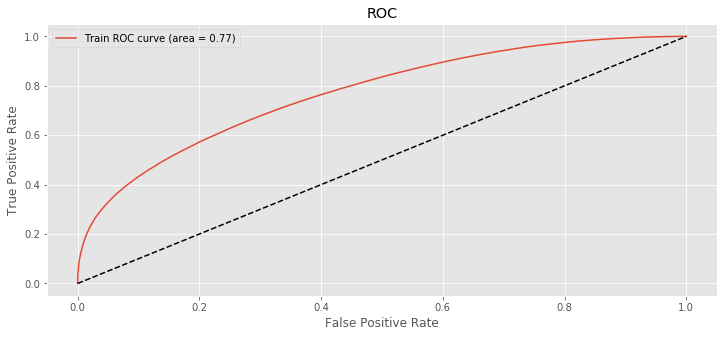

In [23]:
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y, model.predict_proba(X))
roc_auc_train = auc(fpr_train, tpr_train)

plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="best")

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [29]:
filepath = './testData_tabular.csv'
df_data_test = pd.read_csv(filepath, sep=',')

In [30]:
df_data_test.shape

(750000, 45)

In [31]:
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [32]:
df_data_test.head().T

gamestate_id                   6845857.0  9279433.0  6642076.0  9169516.0  \
decision                             NaN        NaN        NaN        NaN   
turn                                12.0        6.0       14.0        7.0   
opponent_armor                       0.0        0.0        0.0        0.0   
opponent_attack                      0.0        0.0        0.0        0.0   
opponent_hero_card_id              798.0      326.0      390.0      798.0   
opponent_hp                         29.0       12.0       12.0       30.0   
opponent_special_skill_used          1.0        0.0        0.0        0.0   
opponent_weapon_durability           0.0        0.0        0.0        0.0   
opponent_crystals_all               10.0        5.0       10.0        6.0   
opponent_crystals_current            8.0        5.0        0.0        6.0   
opponent_deck_count                 16.0       22.0       11.0       20.0   
opponent_fatigue_damage              0.0        0.0        0.0        0.0   
opponent_hand_count                  6.0        8.0        5.0        7.0   
opponent_played_minions_count        2.0        0.0        3.0        2.0   
player_armor                         0.0        0.0        0.0        0.0   
player_attack                        0.0        0.0        0.0        0.0   
player_hero_card_id                798.0      612.0      798.0      390.0   
player_hp                           28.0       29.0       24.0       24.0   
player_special_skill_used            0.0        0.0        0.0        0.0   
player_weapon_durability             0.0        0.0        0.0        0.0   
player_crystals_all                 10.0        6.0       10.0        7.0   
player_crystals_current             10.0        0.0        6.0        7.0   
player_deck_count                   15.0       21.0       12.0       18.0   
player_fatigue_damage                0.0        0.0        0.0        0.0   
player_hand_count                    5.0        5.0        3.0        6.0   
player_played_minions_count          1.0        3.0        3.0        1.0   
opponent_played_nOfCards             2.0        0.0        3.0        2.0   
opponent_played_attack               6.0        0.0        8.0        7.0   
opponent_played_crystals_cost        5.0        0.0       10.0        6.0   
opponent_played_hp_current           6.0        0.0       12.0        7.0   
opponent_played_hp_max               6.0        0.0       12.0        8.0   
player_played_nOfCards               1.0        3.0        3.0        1.0   
player_played_attack                 4.0       15.0       14.0        6.0   
player_played_crystals_cost          4.0       13.0       15.0        6.0   
player_played_hp_current             3.0       15.0        9.0        7.0   
player_played_hp_max                 5.0       15.0       19.0        7.0   
player_hand_nOfMinions               5.0        3.0        2.0        4.0   
player_hand_nOfSpells                0.0        2.0        1.0        2.0   
player_hand_nOfWeapons               0.0        0.0        0.0        0.0   
player_hand_nOfCards                 5.0        5.0        3.0        6.0   
player_hand_nOfPlayable              5.0        0.0        3.0        6.0   
player_hand_attack                  16.0       16.0        7.0       13.0   
player_hand_crystals_cost           17.0       28.0       10.0       20.0   
player_hand_hp                      20.0       19.0        7.0       15.0   

gamestate_id                   8991397.0  
decision                             NaN  
turn                                 9.0  
opponent_armor                       0.0  
opponent_attack                      0.0  
opponent_hero_card_id              326.0  
opponent_hp                         30.0  
opponent_special_skill_used          1.0  
opponent_weapon_durability           0.0  
opponent_crystals_all                8.0  
opponent_crystals_current            2.0  
opponent_deck_count                 19.0  
opponent_fatigue_d

In [33]:
ohe_opponent = pd.get_dummies(df_data_test.opponent_hero_card_id, prefix='opponent_hero_card_id', prefix_sep='=')
ohe_player = pd.get_dummies(df_data_test.player_hero_card_id, prefix='player_hero_card_id', prefix_sep='=')
df_data_test = pd.concat([df_data_test.drop(['player_hero_card_id','opponent_hero_card_id'],axis=1),\
                     ohe_player.iloc[:,:-1],ohe_opponent.iloc[:,:-1]],axis=1)
X_test, y_test = df_data_test.iloc[:, 1:].values, df_data_test.iloc[:, 0].values

In [237]:
mod = MySGDClassifier(C=0.01, alpha=0.6, n_batch=30, max_epoch=100)
mod.fit(X[:400000],y[:400000])

1
nan
nan


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[  1.26334811   0.67571886   1.01244126  -9.13094412   0.99740164
   1.02646934   1.21859567   1.90591993   0.40148662   1.01241322
   1.13548616  -0.67417321   1.37071187   1.00655889  10.0331898
   0.97281649   0.9558968    1.25726824   1.40677641   0.45295454
   0.99508883   0.86784948   2.83318238  -0.67417321  -6.03668731
  -5.26236426  -5.30238593  -7.00896119   2.83318238   8.86636924
   7.91659133   7.72122919   9.87995679   1.1991606    0.74188582
   0.92677606   0.86784948   1.0085375    2.51820067   1.57667431
   2.77681285   0.97304644   1.00876224   0.96680154   0.97405795
   1.01027451   0.97204959   1.05088988   1.0189833    1.00252924
   0.98763415   1.01335138   1.01320997   0.98337449   1.02141513
   0.96671231   0.99288442   0.9848619 ]
2
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


MySGDClassifier(C=0.01, alpha=0.6, max_epoch=100, n_batch=30)

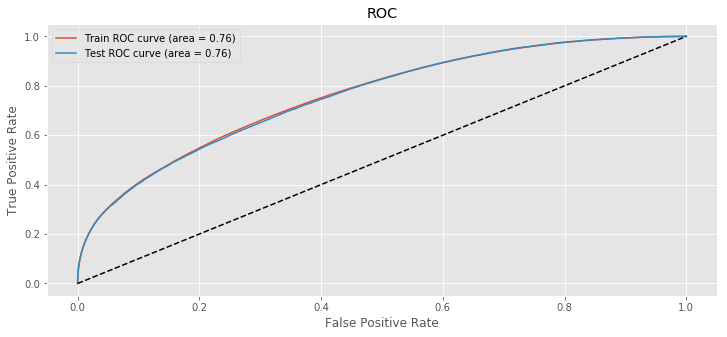

In [239]:
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y[:400000], mod.predict_proba(X[:400000]))
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y[400000:], mod.predict_proba(X[400000:]))
roc_auc_test = auc(fpr_test, tpr_test)

plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="best")

In [34]:
y_h = model.predict_proba(X_test)

In [54]:
np.savetxt('./output.txt', y_h, fmt='%8f', delimiter='\n')

(750000L,)